<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/jupyter/basic_OOK_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulate a OOK transmission system with an advanced EDFA model

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [ ]:
import numpy as np
from optic.models.devices import mzm, photodiode, voa
from optic.dsp.core import upsample, signalPower, pulseShape, anorm, pnorm
from optic.comm.modulation import modulateGray
from optic.comm.sources import bitSource
from optic.utils import parameters, dBm2W
from optic.plot import eyediagram
import matplotlib.pyplot as plt
from scipy.special import erfc

try:
    from optic.dsp.coreGPU import checkGPU
    if checkGPU():
        from optic.dsp.coreGPU import firFilter
    else:
        from optic.dsp.core import firFilter
except ImportError:
    from optic.dsp.core import firFilter
    
from scipy.constants import c
from optic.models.amplification import edfaSM,OSA

import os.path as path

In [3]:
import logging as logg
logg.getLogger().setLevel(logg.INFO)
logg.basicConfig(format='%(message)s')

In [4]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

In [5]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [6]:
figsize(10, 3)

### Intensity modulation (IM) with On-Off Keying (OOK)

Average power of the modulated optical signal [mW]: 0.500 mW
Average power of the modulated optical signal [dBm]: -3.008 dBm


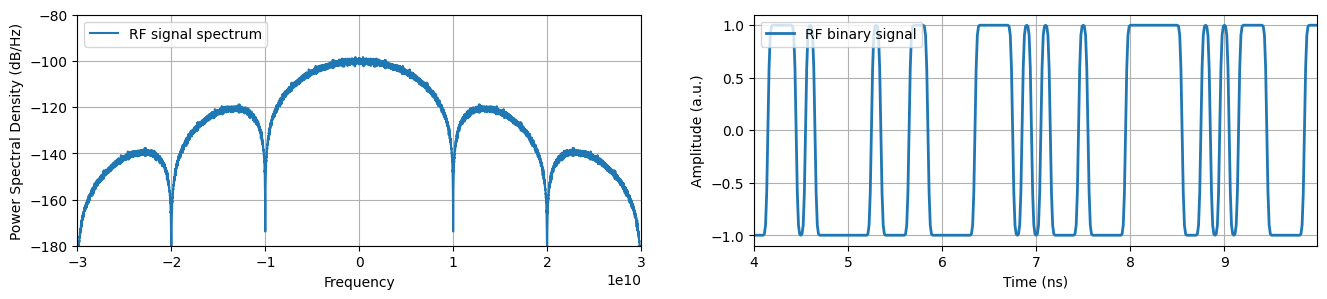

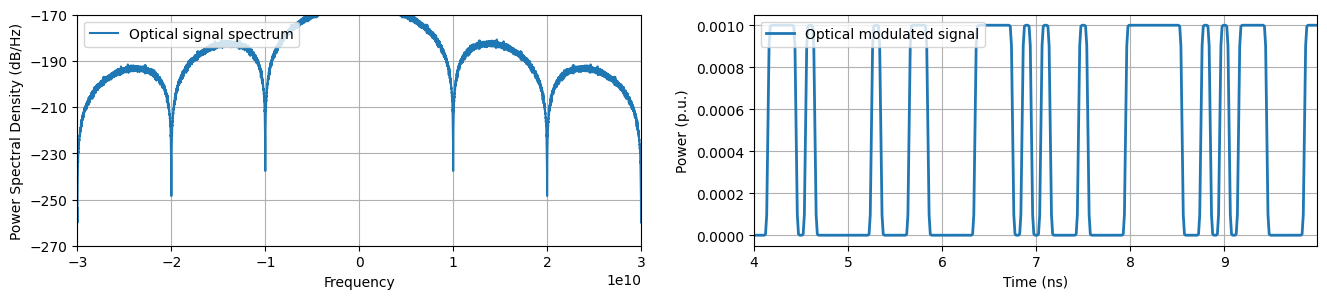

In [ ]:
# simulation parameters
SpS = 8      # samples per symbol
M = 2        # order of the modulation format
Rs = 10e9    # Symbol rate (for OOK case Rs = Rb)
Fs = Rs*SpS  # Sampling frequency
Ts = 1/Fs    # Sampling period
# Laser power
Pi_dBm = 0         # laser optical power at the input of the MZM in dBm
Pi = dBm2W(Pi_dBm) # convert from dBm to W

# Bit source parameters
paramBits = parameters()
paramBits.nBits = 100000  # number of bits to be generated
paramBits.mode = 'prbs'   # mode of the bit source  
paramBits.order = 23      # order of the PRBS
paramBits.seed = 12335    # seed for the random number generator

# pulse shaping parameters
paramPulse = parameters()
paramPulse.pulseType = 'nrz'  # pulse shape type
paramPulse.SpS = SpS     # samples per symbol

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# generate pseudo-random bit sequence
bitsTx = bitSource(paramBits)

# generate 2-PAM modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulse shaping
pulse = pulseShape(paramPulse)
sigTx = firFilter(pulse, symbolsUp)

sigTx = anorm(sigTx)  # power normalization

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = mzm(Ai, sigTx, paramMZM)

print('Average power of the modulated optical signal [mW]: %.3f mW'%(signalPower(sigTxo)/1e-3))
print('Average power of the modulated optical signal [dBm]: %.3f dBm'%(10*np.log10(signalPower(sigTxo)/1e-3)))

fig, axs = plt.subplots(1, 2, figsize=(16,3))
interval = np.arange(16*20,16*50)
t = interval*Ts/1e-9

# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'RF signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, sigTx[interval], label = 'RF binary signal', linewidth=2)
axs[1].set_ylabel('Amplitude (a.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

fig, axs = plt.subplots(1, 2, figsize=(16,3))
# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-270,-170);
axs[0].psd(np.abs(sigTxo)**2, Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Optical signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, np.abs(sigTxo[interval])**2, label = 'Optical modulated signal', linewidth=2)
axs[1].set_ylabel('Power (p.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

### Attenuate the optical signal

In [8]:
att = 20 # attenuation in dB
sigTxo = voa(sigTxo, att).flatten()

## Without optical amplification

### Direct-detection (DD) pin receiver model

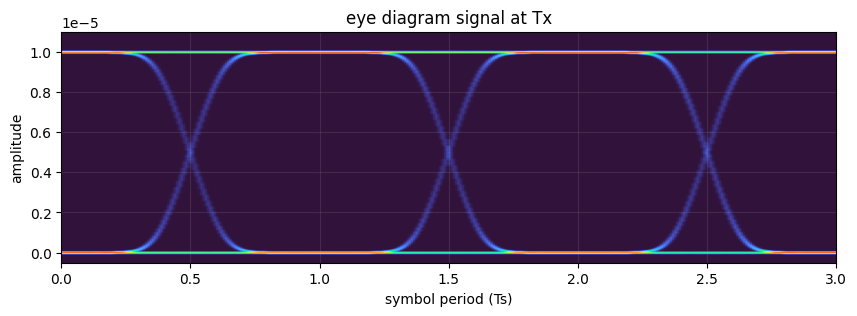

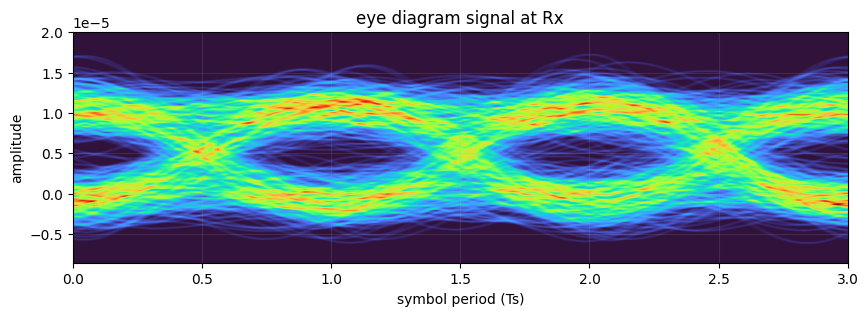

I0 = -0.15 
I1 = 2.14 
σ0 = 0.37 
σ1 = 0.37 
Optimal decision threshold Id = 1.00 
Q = 3.10 



In [9]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
I_Rx_ideal = photodiode(sigTxo.real, paramPD)

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

I_Rx = photodiode(sigTxo.real, paramPD)

discard = 100*SpS

eyediagram(I_Rx_ideal[discard:-discard].copy(), I_Rx.size-2*discard, SpS, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx[discard:-discard].copy(), I_Rx.size-2*discard, SpS, plotlabel='signal at Rx', ptype='fancy')

I_Rx = I_Rx/np.std(I_Rx)

# capture samples in the middle of signaling intervals
I_Rx = I_Rx[0::SpS]

# get received signal statistics
I1 = np.mean(I_Rx[bitsTx==1]) # average value of I1
I0 = np.mean(I_Rx[bitsTx==0]) # average value of I0

σ1 = np.std(I_Rx[bitsTx==1]) # standard deviation σ1 of I1
σ0 = np.std(I_Rx[bitsTx==0]) # standard deviation σ0 of I0

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
Q = (I1-I0)/(σ1 + σ0) # factor Q

print('I0 = %.2f '%(I0))
print('I1 = %.2f '%(I1))
print('σ0 = %.2f '%(σ0))
print('σ1 = %.2f '%(σ1))
print('Optimal decision threshold Id = %.2f '%(Id))
print('Q = %.2f \n'%(Q))

Number of counted errors = 93 
BER = 9.32e-04 
Pb = 9.70e-04 


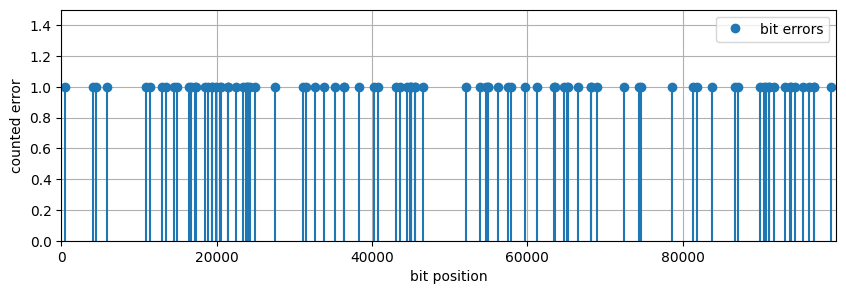

In [10]:
# Apply the optimal decision rule
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx> Id] = 1
bitsRx[I_Rx<= Id] = 0

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
print('Pb = %.2e '%(Pb))

err = err*1.0
err[err==0] = np.nan

plt.plot(err,'o', label = 'bit errors')
plt.vlines(np.where(err>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err.size);

### Optical amplification

Sample rate [THz]: 0.080
Time window [ns]:  10000.000
Central wavelength [nm]: 1550.00
Simulation window  [nm]: 0.641110 - [1549.68 nm - 1550.32 nm]
Frequency spacing [GHz]: 0.000100
Number of points: 800000
Number of modes: 1
Average power - TX [mW] : 0.005 mW
Average power - TX [dBm] : -23.008 dBm


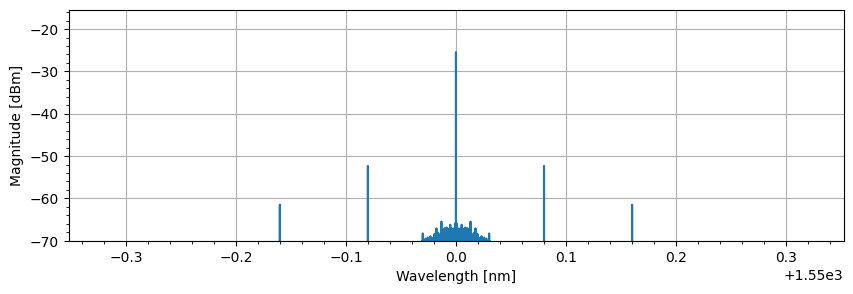

In [11]:
# EDFA parameters
param_edfa = parameters()
# gain control
param_edfa.type     = "AGC"
param_edfa.value    = 20 #dB
# pid - gain control
param_edfa.kp = 2e-3
param_edfa.ki = 0
param_edfa.kd = 0
# pump information
param_edfa.forPump  = {'pump_signal': np.array([100e-3]), 'pump_lambda': np.array([980e-9])}
param_edfa.bckPump  = {'pump_signal': np.array([000e-3]), 'pump_lambda': np.array([980e-9])}
# giles parameters
param_edfa.file     = 'giles_MP980.dat'
param_edfa.fileunit = 'nm'
param_edfa.gmtc     = 'Bessel'
param_edfa.tol      = 0.05
param_edfa.tolCtrl  = 0.5
# ASE
param_edfa.noiseBand= 1.25e9

if 'google.colab' in str(get_ipython()):  
  param_edfa.file = path.join(path.abspath(path.join("../")), 'OptiCommPy', 'optic', 'models', 'ampParams', param_edfa.file)
else:
  param_edfa.file = path.join(path.abspath(path.join("../")), 'optic', 'models', 'ampParams', param_edfa.file)

Fc = c/1550e-9 # central wavelength
Nmodes = 1     # number of modes
sigTxo = np.reshape(sigTxo, (len(sigTxo), 1))
lenFrqSg, isy = np.shape(sigTxo)
simOpticalBand = (Fs*(c/Fc)**2)/c
tx_pw = np.sum(1000*np.mean(sigTxo * np.conj(sigTxo), axis = 0).real)

# information TX
print('Sample rate [THz]: %5.3f' %(1e-12*Fs))
print('Time window [ns]:  %5.3f' %(1e9*lenFrqSg/Fs))
print('Central wavelength [nm]: %6.2f' %(1e9*c/Fc))
print('Simulation window  [nm]: %f - [%6.2f nm - %6.2f nm]' 
      %(1e9*simOpticalBand, 1e9*(c/Fc-simOpticalBand/2), 1e9*(c/Fc+simOpticalBand/2)))
print('Frequency spacing [GHz]: %f' %(1e-9*Fs/lenFrqSg))
print('Number of points: %d' %(lenFrqSg))
print('Number of modes: %d' %(Nmodes))
print('Average power - TX [mW] : %.3f mW' %(tx_pw))
print('Average power - TX [dBm] : %.3f dBm' %(10*np.log10(tx_pw)))

OSA(sigTxo, Fs, Fc);

In [12]:
Eout, PumpF, PumpB, noisef = edfaSM(sigTxo, Fs, Fc, param_edfa)


EDF absorption and gain coeficients. Calculating absorption and emission cross-section ...
EDFA SM: loop  1
Convergence: -0.045%.

EDFA SM: control loop  1
Convergence: 11.431 dB
Pump for.: 77.14 mW

EDFA SM: loop  1
Convergence: -29.606%.

EDFA SM: loop  2
Convergence: 0.058%.

EDFA SM: control loop  2
Convergence: 10.967 dB
Pump for.: 55.20 mW

EDFA SM: loop  1
Convergence: -39.667%.

EDFA SM: loop  2
Convergence: 0.098%.

EDFA SM: control loop  3
Convergence: 10.194 dB
Pump for.: 34.81 mW

EDFA SM: loop  1
Convergence: -58.431%.

EDFA SM: loop  2
Convergence: 0.138%.

EDFA SM: control loop  4
Convergence: 8.679 dB
Pump for.: 17.46 mW

EDFA SM: loop  1
Convergence: -99.240%.

EDFA SM: loop  2
Convergence: 0.124%.

EDFA SM: control loop  5
Convergence: 4.652 dB
Pump for.:  8.73 mW

EDFA SM: loop  1
Convergence: -99.925%.

EDFA SM: loop  2
Convergence: 0.055%.

EDFA SM: control loop  6
Convergence: -5.558 dB
Pump for.: 13.09 mW

EDFA SM: loop  1
Convergence: 33.306%.

EDFA SM: loop  2

Forward pump  - [mW] : 12.983
Backward pump - [mW] : 0.000
Average power - RX amp [mW] : 0.717
Average power - RX amp [dBm] : -1.447
Gain [dB]: 21.561


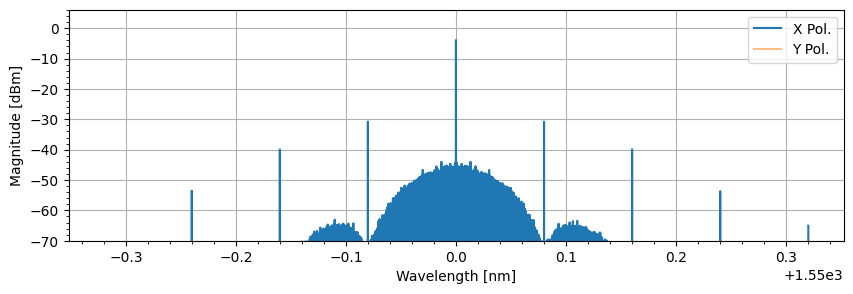

In [13]:
rx_pw = np.sum(1000*np.mean(Eout * np.conj(Eout), axis = 0).real)
print('Forward pump  - [mW] : %.3f' %(1e3*PumpF[0]))
print('Backward pump - [mW] : %.3f' %(1e3*PumpB[1]))
print('Average power - RX amp [mW] : %.3f' %(rx_pw))
print('Average power - RX amp [dBm] : %.3f' %(10*np.log10(rx_pw)))
print('Gain [dB]: %.3f' %(10*np.log10(rx_pw/tx_pw)))

OSA(Eout, Fs, Fc);

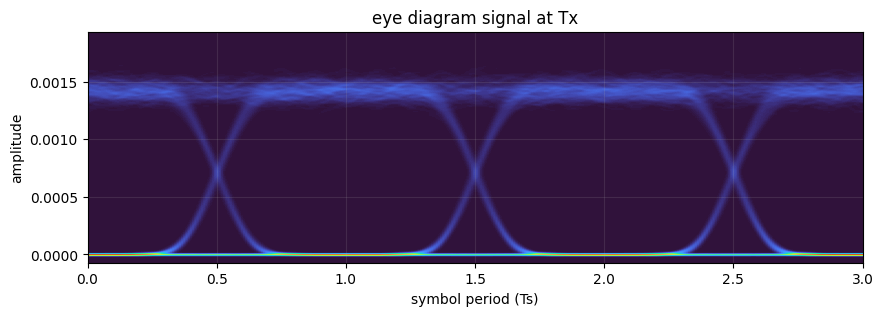

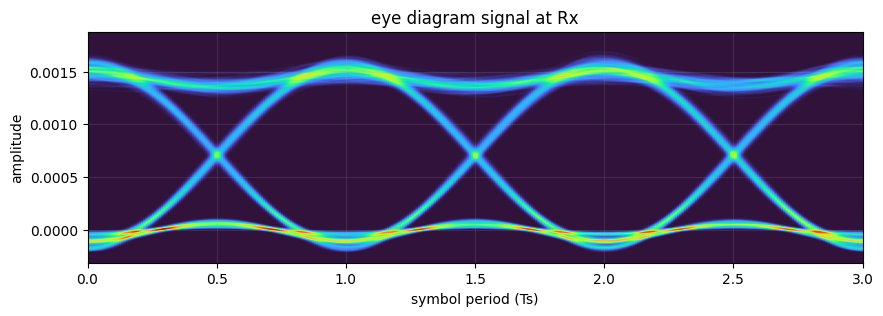

I0 = -0.16 
I1 = 2.29 
σ0 = 0.07 
σ1 = 0.09 
Optimal decision threshold Id = 0.95 
Q = 15.62 

Number of counted errors = 0 
BER = 0.00e+00 
Pb = 2.66e-55 


(0.0, 99800.0)

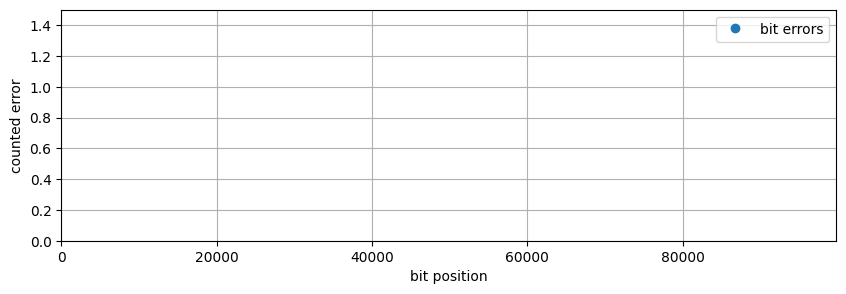

In [14]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
I_Rx_Amp_ideal = photodiode(Eout[:,0].real, paramPD)

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

I_Rx_Amp = photodiode(Eout[:,0].real, paramPD)

discard = 100*SpS

eyediagram(I_Rx_Amp_ideal[discard:-discard].copy(), I_Rx_Amp.size-2*discard, SpS, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx_Amp[discard:-discard].copy(), I_Rx_Amp.size-2*discard, SpS, plotlabel='signal at Rx', ptype='fancy')

I_Rx_Amp = I_Rx_Amp/np.std(I_Rx_Amp)

# capture samples in the middle of signaling intervals
I_Rx_Amp = I_Rx_Amp[0::SpS]

# get received signal statistics
I1 = np.mean(I_Rx_Amp[bitsTx==1]) # average value of I1
I0 = np.mean(I_Rx_Amp[bitsTx==0]) # average value of I0

σ1 = np.std(I_Rx_Amp[bitsTx==1]) # standard deviation σ1 of I1
σ0 = np.std(I_Rx_Amp[bitsTx==0]) # standard deviation σ0 of I0

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
Q = (I1-I0)/(σ1 + σ0) # factor Q

print('I0 = %.2f '%(I0))
print('I1 = %.2f '%(I1))
print('σ0 = %.2f '%(σ0))
print('σ1 = %.2f '%(σ1))
print('Optimal decision threshold Id = %.2f '%(Id))
print('Q = %.2f \n'%(Q))

# Apply the optimal decision rule
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx_Amp> Id] = 1
bitsRx[I_Rx_Amp<= Id] = 0

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
print('Pb = %.2e '%(Pb))

err = err*1.0
err[err==0] = np.nan

plt.plot(err,'o', label = 'bit errors')
plt.vlines(np.where(err>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err.size)